In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
# data = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
# !python -m wget $data

In [3]:
df = pd.read_csv("bank+marketing/bank/bank-full.csv", sep=";")
df = df.drop(["default", "loan"], axis=1)
df["y"] = (df.y == "yes").astype(int)

df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_valid = df_valid.y.values
y_test = df_test.y.values

del df_train["y"]
del df_valid["y"]
del df_test["y"]

### No. 1

In [6]:
numerical = df_train.select_dtypes(include="number").columns

for num in numerical:
    auc = roc_auc_score(y_train, df_train[num])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[num])

    print("%s: %.3f" % (num, auc))

age: 0.512
balance: 0.589
day: 0.526
duration: 0.815
campaign: 0.571
pdays: 0.590
previous: 0.599


### No. 2

In [8]:
def train(df_train, y_train, C = 1.0):
    dicts = df_train.to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [9]:
dv, model = train(df_train, y_train)

In [10]:
def predict(df, dv, model):
    dicts = df.to_dict(orient="records")
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [11]:
y_pred = predict(df_valid, dv, model)

In [12]:
roc_auc_score(y_valid, y_pred).round(3)

0.9

### No. 3

In [14]:
def confusion_matrix(y_valid, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        actual_positive = (y_valid == 1)
        actual_negative = (y_valid == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))
    
    columns = ["thresholds", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores["precision"] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)

    return df_scores

In [15]:
df_scores = confusion_matrix(y_valid, y_pred)
df_scores[::10]

,thresholds,tp,fp,fn,tn,precision,recall
0,0.0,1098,7944,0,0,0.121433,1.000000
10,0.1,926,1494,172,6450,0.382645,0.843352
20,0.2,711,691,387,7253,0.507133,0.647541
30,0.3,565,412,533,7532,0.578301,0.514572
40,0.4,459,273,639,7671,0.627049,0.418033
50,0.5,371,193,727,7751,0.657801,0.337887
60,0.6,290,137,808,7807,0.679157,0.264117
70,0.7,224,102,874,7842,0.687117,0.204007
80,0.8,148,69,950,7875,0.682028,0.134791
90,0.9,77,28,1021,7916,0.733333,0.070128


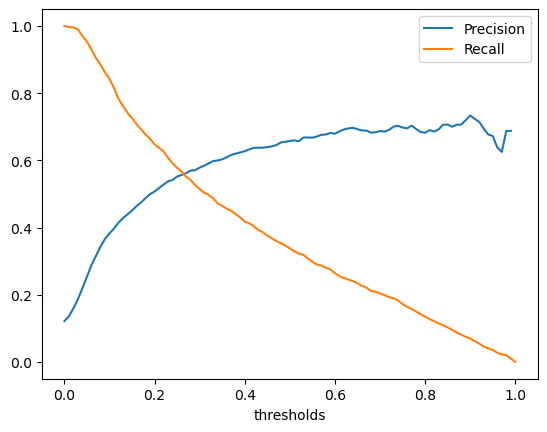

In [16]:
plt.plot(df_scores.thresholds, df_scores.precision, label = "Precision")
plt.plot(df_scores.thresholds, df_scores.recall, label = "Recall")

plt.xlabel("thresholds")

plt.legend()

### No. 4

In [18]:
df_scores["f1-score"] = 2* ((df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))

df_scores

,thresholds,tp,fp,fn,tn,precision,recall,f1-score
0,0.00,1098,7944,0,0,0.121433,1.000000,0.216568
1,0.01,1094,6974,4,970,0.135597,0.996357,0.238708
2,0.02,1093,5768,5,2176,0.159306,0.995446,0.274658
3,0.03,1087,4727,11,3217,0.186963,0.989982,0.314525
4,0.04,1065,3800,33,4144,0.218911,0.969945,0.357203
...,...,...,...,...,...,...,...,...
96,0.96,30,17,1068,7927,0.638298,0.027322,0.052402
97,0.97,25,15,1073,7929,0.625000,0.022769,0.043937
98,0.98,22,10,1076,7934,0.687500,0.020036,0.038938
99,0.99,11,5,1087,7939,0.687500,0.010018,0.019749


In [19]:
f1_score_max = df_scores["f1-score"].max()

df_scores[df_scores["f1-score"] == f1_score_max]

,thresholds,tp,fp,fn,tn,precision,recall,f1-score
22,0.22,688,615,410,7329,0.528012,0.626594,0.573095


### No. 5

In [21]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [22]:
train_idx, valid_idx = next(kfold.split(df_full_train))
train_idx, valid_idx

(array([    0,     1,     4, ..., 36165, 36166, 36167]),
 array([    2,     3,    11, ..., 36148, 36154, 36163]))

In [23]:
scores = []

for train_idx, valid_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_valid = df_full_train.iloc[valid_idx]

    y_train = df_train.y.values
    y_valid = df_valid.y.values

    del df_train["y"]
    del df_valid["y"]

    dv, model = train(df_train, y_train)
    y_pred = predict(df_valid, dv, model)

    auc = roc_auc_score(y_valid, y_pred)
    scores.append(auc)

In [24]:
scores

[0.8993883806356288,
 0.8989055268937651,
 0.9112102229960733,
 0.9080952264469403,
 0.9100912737695956]

In [25]:
print("STD: %.3f" % np.std(scores))

STD: 0.005


### No. 6

In [27]:
scores = []

for C in ([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    
    for train_idx, valid_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_valid = df_full_train.iloc[valid_idx]
    
        y_train = df_train.y.values
        y_valid = df_valid.y.values
        
        del df_train["y"]
        del df_valid["y"]
    
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_valid, dv, model)
    
        auc = roc_auc_score(y_valid, y_pred)
        scores.append(auc)

    print("C = %s %.3f" % (C, np.mean(scores)))

C = 1e-06 0.701
C = 0.001 0.861
C = 1 0.906
